In [3]:
import numpy as onp
import matplotlib.pyplot as plt

from scipy.special import j1

import jax.numpy as np 
from jax import grad, jit, vmap

from astropy.table import Table

from zodiax import Base # use this for object oriented Jax

from sibylla_lite import *

from jax import config
config.update("jax_enable_x64", True)


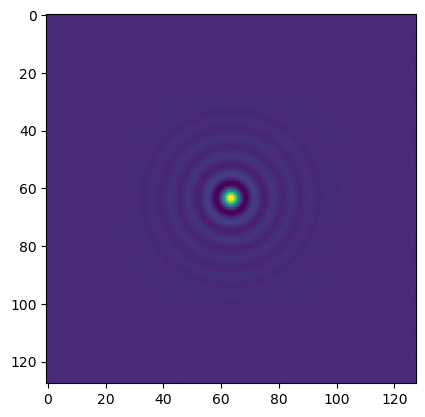

In [7]:
pscale, npix = 65/2, 128
x = onp.linspace(-npix//2*pscale,npix//2 * pscale,npix)
xx, yy = onp.meshgrid(x, x)
rr = np.sqrt(xx**2 + yy**2)
image = j1(rr/pscale)/rr

plt.imshow(image)

# create uv coordinates
uu, vv = onp.meshgrid(onp.linspace(-5,5,128), onp.linspace(-5,5,128))
uv = np.vstack([uu.flatten(), vv.flatten()]).T

In [8]:
%%time
transform = UVNonUniform(uv,xx,yy,4.3e-6)

CPU times: user 3.24 s, sys: 998 ms, total: 4.24 s
Wall time: 4.24 s


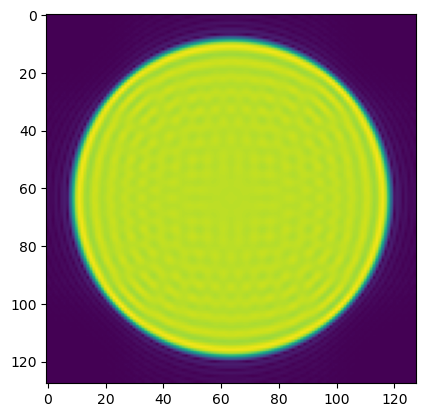

In [9]:
ft = transform(image).reshape(vv.shape)
plt.imshow(np.abs(ft))

In [216]:
coords, residuals =   np.load('coords.npy', allow_pickle=True)*1000,  np.load('residual.npy', allow_pickle=True)
coords = coords - np.array(coords[:,54,31])[:,np.newaxis,np.newaxis]

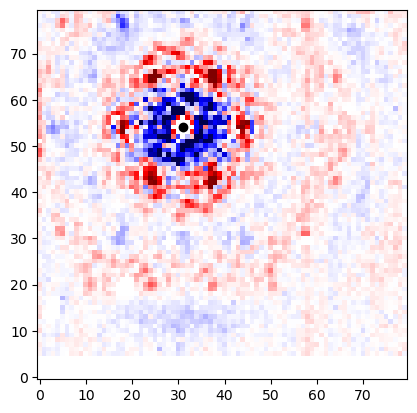

In [220]:
nanmask = ~np.isnan(residuals).flatten()
vmax = np.percentile(np.abs(residuals.flatten()[nanmask]),99)
vmin = -vmax
plt.imshow(residuals,cmap='seismic',vmin=vmin,vmax=vmax,origin='lower')

plt.scatter(31,54,c='k')

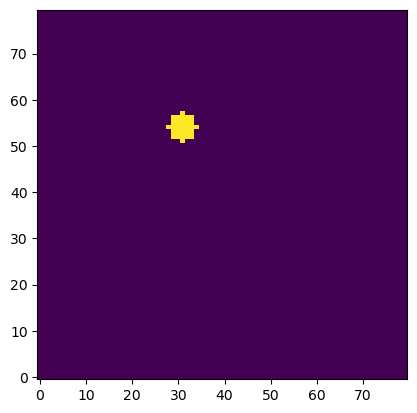

In [174]:
# subtract a coordinate np.array([31,54]) to coords, with broadcasting
plt.imshow(np.sqrt(coords[0]**2 + coords[1]**2)<200,origin='lower')

In [364]:
%%time

wavel = 4.8e-6
uvmax = 6 
uu, vv = onp.meshgrid(onp.linspace(-uvmax,uvmax,128), onp.linspace(-uvmax,uvmax,128))
uv = np.vstack([uu.flatten(), vv.flatten()]).T

transform = UVNonUniform(uv,coords[0].flatten()[nanmask.flatten()],coords[1].flatten()[nanmask.flatten()],wavel)

CPU times: user 1.28 s, sys: 471 ms, total: 1.75 s
Wall time: 1.76 s


Text(0, 0.5, 'v (m)')

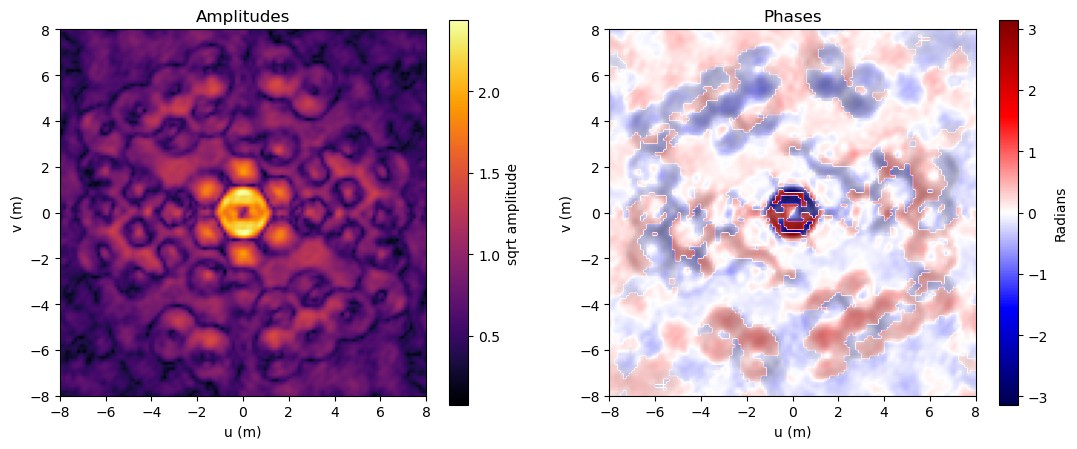

In [315]:
ft = transform(residuals.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = onp.abs(ft)
mask = np.sqrt(uu**2 + vv**2) < 10
amps[~mask] = 0

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = onp.angle(ft).copy()

im2 = ax2.imshow(phases,alpha=((amps-amps.min())/(amps.max()-amps.min()))**0.5, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')


In [16]:
fft2, fftshift = np.fft.fft2, np.fft.fftshift
ifft2, ifftshift = np.fft.ifft2, np.fft.ifftshift
# pad ft before fft
newft = onp.copy(ft)
newft[~mask] = 0+0j
newft = np.pad(newft, 128//2, mode='minimum')

inverse = fftshift(ifft2(fftshift(newft)))

NameError: name 'ft' is not defined

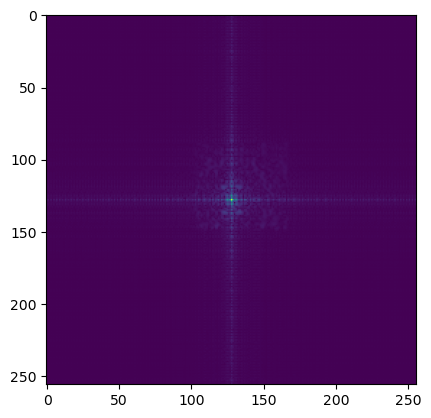

In [300]:
plt.imshow(np.abs(inverse)**0.5)

([], [])

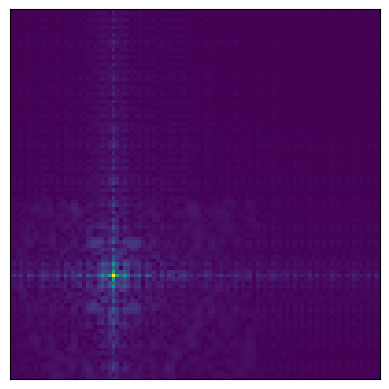

In [302]:
plt.imshow(np.abs(inverse)**0.5)
plt.xticks([])
plt.yticks([])


In [213]:
# now let's calculate the window function
# we'll use the same uv coordinates as before
residuals.flatten()[nanmask]
window = transform(np.ones_like(residuals).flatten()[nanmask]*1.0).reshape(uu.shape)


Text(0, 0.5, 'v (m)')

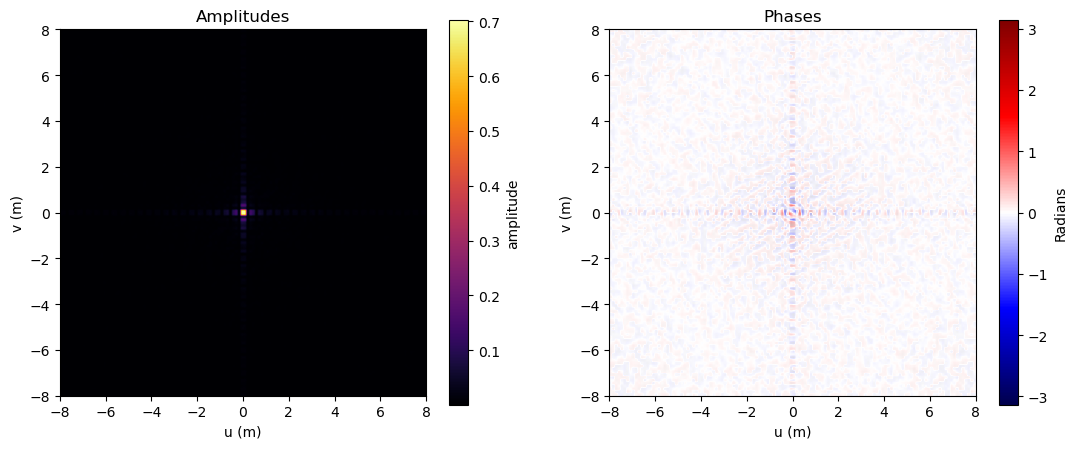

In [215]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(window).copy()
im1 = ax1.imshow(amps,extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno')
fig.colorbar(im1, ax=ax1,label='amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = onp.angle(window).copy()

im2 = ax2.imshow(phases,alpha=((amps-amps.min())/(amps.max()-amps.min()))**0.5, cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax])
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')


In [342]:
psf = np.load('psf.npy', allow_pickle=True)
full_transform = UVNonUniform(uv,coords[0].flatten(),coords[1].flatten(),wavel)

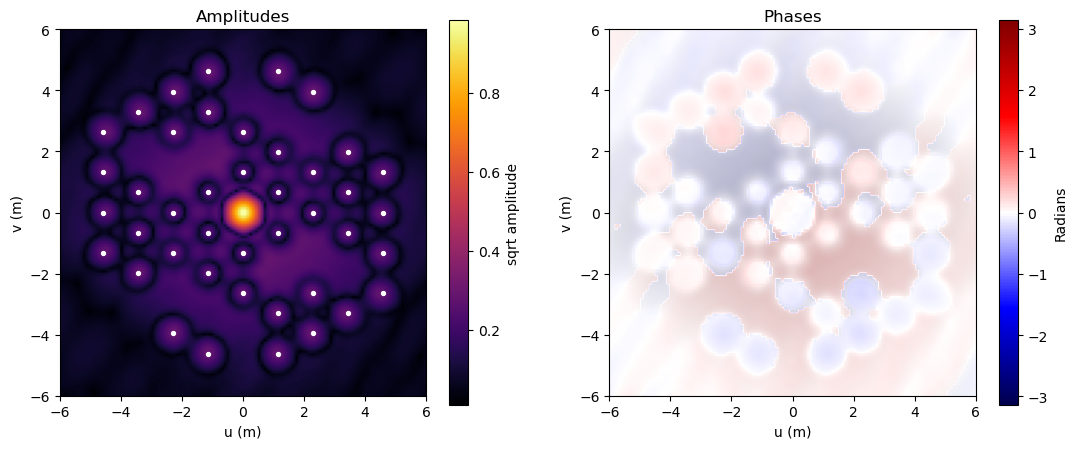

In [378]:
ft = transform(psf.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = onp.abs(ft)
mask = np.sqrt(uu**2 + vv**2) < 10

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = onp.angle(ft).copy()

im2 = ax2.imshow(phases,alpha=((amps-amps.min())/(amps.max()-amps.min()))**0.5, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')
ax1.scatter(bls[:,1],bls[:,0],s=8,c='w')
ax1.scatter(-bls[:,1],-bls[:,0],s=8,c='w')


Text(0, 0.5, 'v (m)')

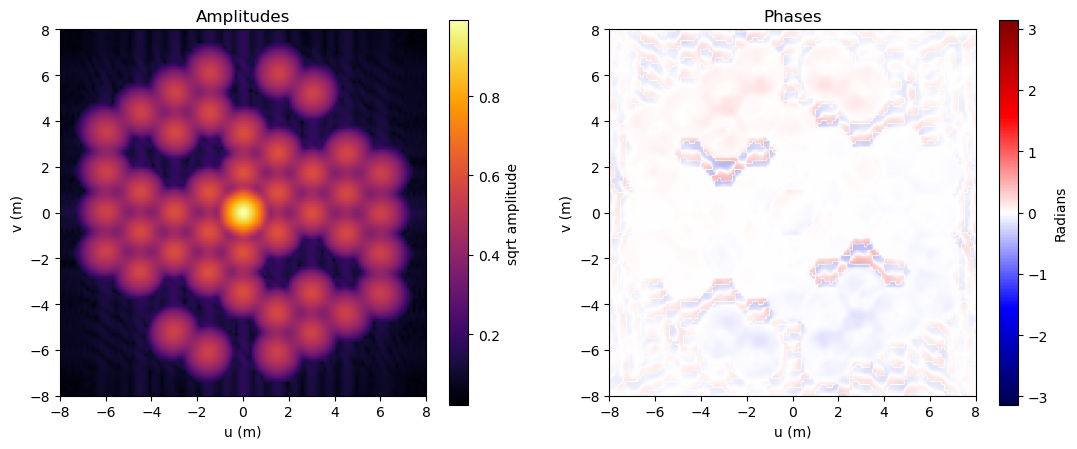

In [355]:
ft_true = full_transform(psf.flatten()).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps_true = onp.abs(ft_true)
# mask = np.sqrt(uu**2 + vv**2) < 10

im1 = ax1.imshow(amps_true**0.25,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases_true = onp.angle(ft_true).copy()

im2 = ax2.imshow(phases_true,alpha=((amps-amps.min())/(amps.max()-amps.min())), 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')


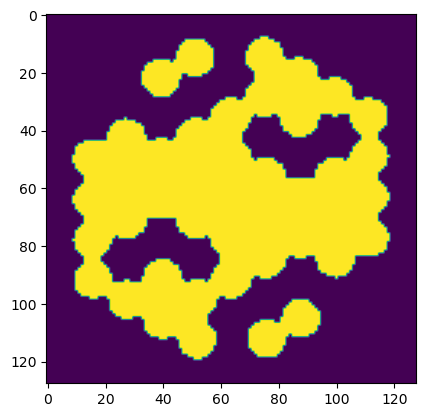

In [358]:
mask = (amps_true**0.5>(amps_true.max()**0.5/7.5))
plt.imshow(mask)


In [359]:
from nrm_analysis.misctools import mask_definitions
f2f,jwst_mask = mask_definitions.jwst_g7s6c()

def makebaselines(mask):
    """
    ctrs_eqt (nh,2) in m
    returns np arrays of eg 21 baselinenames ('0_1',...), eg (21,2) baselinevectors (2-floats)
    in the same numbering as implaneia
    """
    nholes = mask.shape[0]
    blist = []
    for i in range(nholes):
        for j in range(nholes):
            if i < j:
                blist.append((i, j))
    barray = np.round(onp.array(blist)).astype(int)
    # blname = []
    bllist = []
    for basepair in blist:
        # blname.append("{0:d}_{1:d}".format(basepair[0],basepair[1]))
        baseline = mask[basepair[0]] - mask[basepair[1]]
        bllist.append(baseline)
    return barray, np.array(bllist)


barray, bls = makebaselines(jwst_mask)


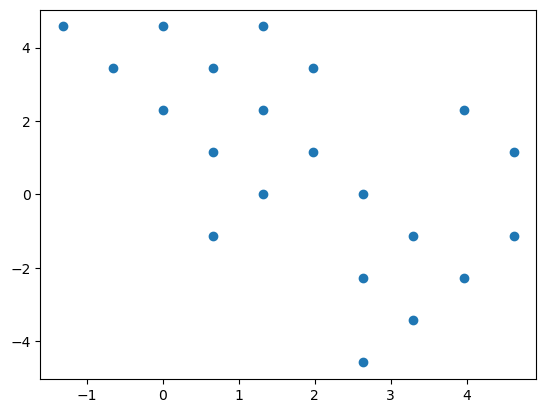

In [360]:
plt.scatter(bls[:,0],bls[:,1])

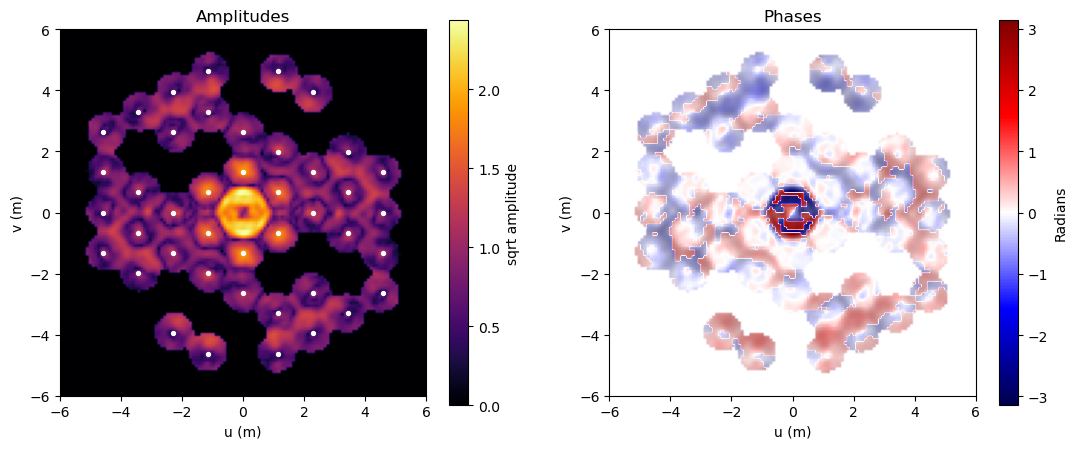

In [377]:
ft = transform(residuals.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = onp.abs(ft)
amps[~mask] = 0.0

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = onp.angle(ft).copy()

im2 = ax2.imshow(phases,alpha=((amps-amps.min())/(amps.max()-amps.min()))**0.5, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')

ax1.scatter(bls[:,1],bls[:,0],s=8,c='w')
ax1.scatter(-bls[:,1],-bls[:,0],s=8,c='w')


In [397]:
from nrm_analysis.fringefitting.hextransformEE import hextransform
from nrm_analysis.misctools.utils import Affine2d

mx, my = 1.0, 1.0
sx, sy= 0.0, 0.0
xo, yo= 0.0, 0.0
affine_ideal = Affine2d(mx=mx,my=my, 
                        sx=sx,sy=sy, 
                        xo=xo,yo=yo, name="Ideal")



In [401]:
hextransform(d=0.82, lam=4.8e-6, s=onp.array([0,0]),c=onp.array([0,0]),pitch=0.065*3600*np.pi/180,affine2d=affine_ideal)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [1]:
from dLux import utils as dlu

I0000 00:00:1698219675.808908       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


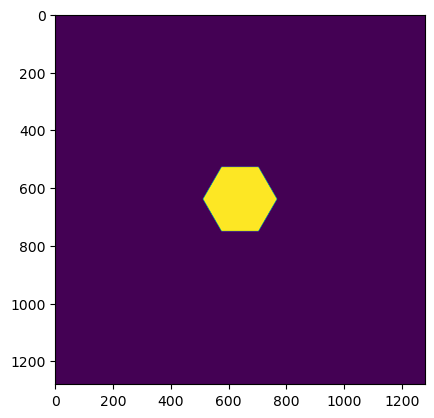

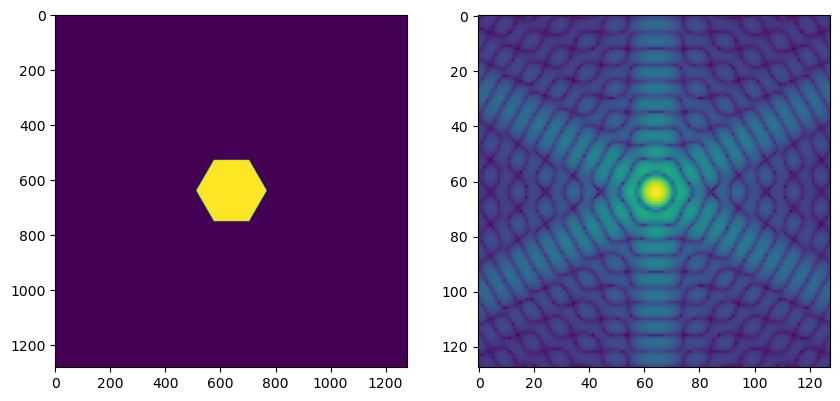

In [30]:
f2f = 0.82
rmax = f2f / np.sqrt(3)
coords = dlu.pixel_coords(256, 2 * rmax)
hex = dlu.reg_polygon(coords, rmax, 6)
hex = np.pad(hex,512,constant_values=0)
plt.imshow(hex)

f2f = 0.82
rmax = f2f / np.sqrt(3)
coords = dlu.pixel_coords(256, 2 * rmax)
hex2 = dlu.reg_polygon(coords, rmax*1.05, 6)
hex2 = np.pad(hex2,512,constant_values=0)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(hex)

sz = hex.shape[0]

sz = hex.shape[0]

ft = fftshift(fft2(fftshift(hex)))
ft = ft[sz//2 - 64:sz//2 + 64, sz//2 - 64:sz//2 + 64]
ax2.imshow(np.abs(ft)**0.25)

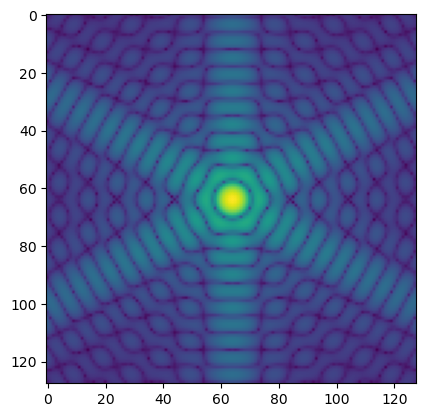